In [41]:
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd
import re
from multiprocessing import Pool
import textwrap
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 6]

# Obtener la ubicacion de los usuarios

In [58]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="63333",
    database="stack_overflow",
)

In [3]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("select count(*) from users where id > 0")
        user_count = cursor.fetchall()[0][0]

In [4]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            "select id, location from users where location is not null and id > 0;"
        )
        locations = cursor.fetchall()

In [5]:
print(
    f"Usuarios totales: {user_count}, usuarios con ubicacion: {len(locations)} ({len(locations)*100/user_count:.2f}%)"
)
print(f"Muestra de las ubicaciones: {locations[:4]}")

Usuarios totales: 19307010, usuarios con ubicacion: 4114054 (21.31%)
Muestra de las ubicaciones: [(1, 'El Cerrito, CA'), (2, 'Corvallis, OR'), (3, 'Johnson City, TN, USA'), (4, 'New York, NY')]


# Datos de los nombres de paises y ciudades

Los dataframes fueron creados con los archivos cities5000.txt, admin1CodesASCII.txt y countryInfo.txt de https://download.geonames.org/export/dump/

In [7]:
cities_df = pd.read_csv(
    "cities5000.txt", delimiter="\t", header=None, usecols=[1, 2, 3, 8]
)
countries_df = pd.read_csv(
    "countryInfo.txt", delimiter="\t", usecols=["ISO", "Country"]
)
cities_df = cities_df.join(countries_df.set_index("ISO"), on=8)
cities_df.head()

,1,2,3,8,Country
0,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",AD,Andorra
1,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",AD,Andorra
2,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",AD,Andorra
3,la Massana,la Massana,"La Macana,La Massana,La Maçana,La-Massana,la M...",AD,Andorra
4,Encamp,Encamp,"Ehnkam,Encamp,en kan pu,enkanpu jiao qu,Энкам,...",AD,Andorra


In [8]:
admin1_df = pd.read_csv(
    "admin1CodesASCII.txt", delimiter="\t", header=None, usecols=[0, 1, 2]
)
admin1_df["c_code"] = admin1_df[0].str.split(".", expand=True)[0]
admin1_df = admin1_df.join(countries_df.set_index("ISO"), on="c_code")
admin1_df.head()

,0,1,2,c_code,Country
0,AD.06,Sant Julià de Loria,Sant Julia de Loria,AD,Andorra
1,AD.05,Ordino,Ordino,AD,Andorra
2,AD.04,La Massana,La Massana,AD,Andorra
3,AD.03,Encamp,Encamp,AD,Andorra
4,AD.02,Canillo,Canillo,AD,Andorra


In [9]:
cc_delim_begin = r"\b("
cc_delim_end = r")\b"

cities_df[1] = cities_df[1].str.lower()
cities_df[2] = cities_df[2].str.lower()

admin1_df[1] = admin1_df[1].str.lower()
admin1_df[2] = admin1_df[2].str.lower()

# Creates a regex that search if the name from cities_df in columns 1(city names), 2(city names ascii), 8(country code) or the country name are present.
countries_names = sorted(cities_df["Country"].unique().tolist(), key=len, reverse=True)
countries_names = re.compile(
    cc_delim_begin + "|".join(countries_names) + cc_delim_end, re.IGNORECASE
)
cities_names_1 = sorted(
    cities_df[1].apply(lambda x: re.escape(x)), key=len, reverse=True
)
cities_names_1 = re.compile(
    cc_delim_begin + "|".join(cities_names_1) + cc_delim_end, re.IGNORECASE
)
cities_names_2 = sorted(
    cities_df[~cities_df[2].isna()][2].apply(lambda x: re.escape(x)),
    key=len,
    reverse=True,
)
cities_names_2 = re.compile(
    cc_delim_begin + "|".join(cities_names_2) + cc_delim_end, re.IGNORECASE
)
country_iso = sorted(
    cities_df[~cities_df[8].isna()][8].apply(lambda x: re.escape(x)),
    key=len,
    reverse=True,
)
country_iso = re.compile(
    cc_delim_begin + "|".join(country_iso) + cc_delim_end, re.IGNORECASE
)

# Creates a regex that search if the name from admin1_df in columns 1(admin1 names), 2(admin1 names ascii) are present.
admin1_names_1 = sorted(
    admin1_df[1].apply(lambda x: re.escape(x)), key=len, reverse=True
)
admin1_names_1 = re.compile(
    cc_delim_begin + "|".join(admin1_names_1) + cc_delim_end, re.IGNORECASE
)
admin1_names_2 = sorted(
    admin1_df[2].apply(lambda x: re.escape(x)), key=len, reverse=True
)
admin1_names_2 = re.compile(
    cc_delim_begin + "|".join(admin1_names_2) + cc_delim_end, re.IGNORECASE
)

In [10]:
# Creates a list of tuples containing a regex for every way to name a city and his country
country_regex = cities_df[["Country", 3]].dropna()
country_regex[3] = country_regex[3].apply(lambda x: re.escape(x))
country_regex[3] = (
    cc_delim_begin + country_regex[3].str.replace(",", "|") + cc_delim_end
)
country_regex = country_regex.values
country_regex = [(c, re.compile(r, re.IGNORECASE)) for c, r in country_regex]

# Funcion para buscar el pais

En orden busca en el texto de la ubicacion:
 - el nombre del pais
 - el nombre administrativo de primer nivel en utf-8 y ascii
 - el nombre de la ciudad en utf-8 y ascii
 - los nombres alternativos de la ciudad
 - codigo de 2 letras del nombre del pais (ISO-3166)

In [11]:
def search_country(user_loc):
    user_id, loc_text = user_loc
    try:
        country_match = countries_names.search(loc_text)
        if country_match is not None:
            return (user_id, loc_text, country_match.group(0))

        admin1_match = admin1_names_1.search(loc_text)
        if admin1_match is not None:
            return (
                user_id,
                loc_text,
                admin1_df[admin1_df[1] == admin1_match.group(1).lower()][
                    "Country"
                ].iloc[0],
            )

        admin1_match = admin1_names_2.search(loc_text)
        if admin1_match is not None:
            return (
                user_id,
                loc_text,
                admin1_df[admin1_df[2] == admin1_match.group(1).lower()][
                    "Country"
                ].iloc[0],
            )

        city_match = cities_names_1.search(loc_text)
        if city_match is not None:
            return (
                user_id,
                loc_text,
                cities_df[cities_df[1] == city_match.group(1).lower()]["Country"].iloc[
                    0
                ],
            )

        city_match = cities_names_2.search(loc_text)
        if city_match is not None:
            return (
                user_id,
                loc_text,
                cities_df[cities_df[2] == city_match.group(1).lower()]["Country"].iloc[
                    0
                ],
            )

        for country, c_regex in country_regex:
            if c_regex.search(loc_text) is not None:
                return (user_id, loc_text, country)

        country_match = country_iso.search(loc_text)
        if country_match is not None:
            return (
                user_id,
                loc_text,
                cities_df[cities_df[8] == country_match.group(1).lower()][
                    "Country"
                ].iloc[0],
            )

        return (user_id, loc_text, None)
    except:
        return (user_id, loc_text, "Error")

In [42]:
with Pool(8) as p:
    maped_countries = p.map(search_country, locations)

In [43]:
maped_countries = pd.DataFrame(
    maped_countries, columns=["user_id", "location", "country"]
)

In [44]:
total_loc = len(maped_countries)
na_loc = maped_countries["country"].isna().sum()
error_loc = (maped_countries["country"] == "Error").sum()
matched_loc = total_loc - na_loc - error_loc
print(f"Total de ubicaciones: {total_loc}")
print(f"Ubicaciones que no machearon: {na_loc} ({na_loc*100/total_loc:.2f}%)")
print(
    f"Ubicaciones que fallaron durante el machero: {error_loc} ({error_loc*100/total_loc:.2f}%)"
)
print(f"Ubicaciones macheadas: {matched_loc} ({matched_loc*100/total_loc:.2f}%)")

Total de ubicaciones: 4114054
Ubicaciones que no machearon: 172570 (4.19%)
Ubicaciones que fallaron durante el machero: 22413 (0.54%)
Ubicaciones macheadas: 3919071 (95.26%)


# Paises con mas muestras

In [45]:
pd.concat(
    [
        maped_countries["country"].value_counts()[:10],
        maped_countries["country"].value_counts(normalize=True)[:10],
    ],
    axis=1,
)

,country,country
India,715071,0.181422
United States,573934,0.145614
Canada,149276,0.037873
United Kingdom,134410,0.034101
Germany,132920,0.033723
China,107956,0.027390
Australia,100342,0.025458
Brazil,97365,0.024703
France,84591,0.021462
Pakistan,80769,0.020492


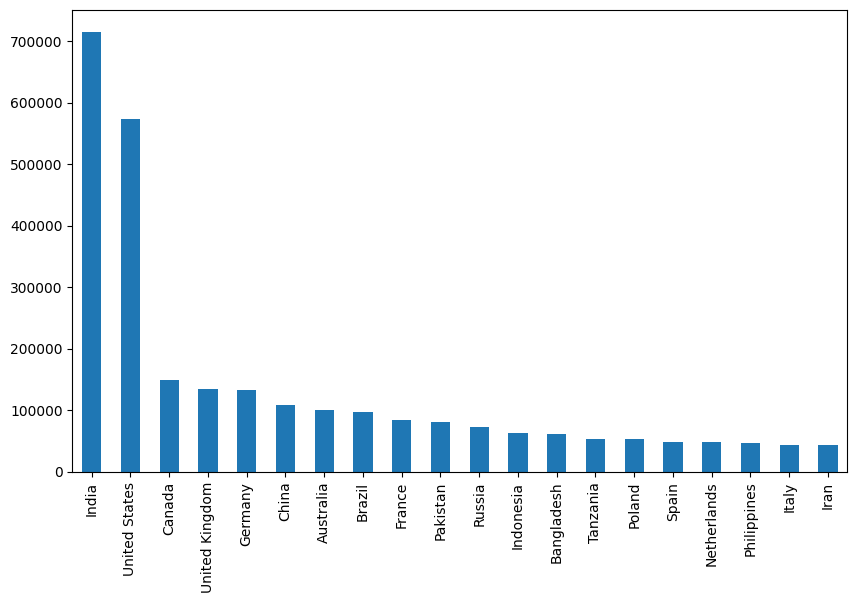

In [46]:
maped_countries["country"].value_counts()[:20].plot(kind="bar");

# Create country column and update values

In [53]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT count(*)
            FROM information_schema.columns
            WHERE table_name = 'users'
            AND column_name = 'country'
        """
        )
        if cursor.fetchall()[0][0] == 0:
            cursor.execute("ALTER TABLE users ADD COLUMN country VARCHAR(255);")
            print("Column created")
        else:
            print("Column already exists")

Column already exists


In [54]:
with connection:
    with connection.cursor() as cursor:
        execute_values(
            cursor,
            """UPDATE users SET country = data.country
                                FROM (VALUES %s) AS data (id, country)
                                WHERE users.id = data.id""",
            maped_countries[["user_id", "country"]].values,
        )

In [62]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            "select id, location, country from users where country is not null limit 6;"
        )
        users_country_sample = cursor.fetchall()
users_country_sample

[(224251, 'California', 'United States'),
 (224254, 'Melbourne, Australia', 'Australia'),
 (226877, 'Bangalore, India', 'India'),
 (227378, 'Finland', 'Finland'),
 (227382, 'Mountain View, CA', 'United States'),
 (227393, 'Atlanta, GA', 'United States')]

# Ubicaciones no encontradas

In [60]:
print("Ubicaciones con errores:")
print(
    textwrap.fill(
        f'{maped_countries[maped_countries["country"] == "Error"]["location"].values.tolist()[:25]}',
        width=80,
    )
)

Ubicaciones con errores:
['Yosemite National Park, CA', 'CA', 'MA', 'Lily, KY', 'Wayzata, MN', 'Bishop,
CA', 'Grayson, GA', 'Rumney, NH, US', 'Seagrove, NC', 'Cambrdige, MA', 'Time,
IL', 'MN', 'CA', 'Trona, CA', 'MA', 'İstanbul, Türkiye', 'CA', 'MN', 'Gillespie,
IL', 'İstanbul, Türkiye', 'US', 'Granite Falls, NC', '.pl', 'Cosmos, MN', 'Dell
Rapids, SD']


In [61]:
print("Ubicaciones sin macheos:")
print(
    textwrap.fill(
        f'{maped_countries[maped_countries["country"].isna()]["location"].values.tolist()[:25]}',
        width=80,
    )
)

Ubicaciones sin macheos:
['Earth, TX', 'UK', 'Jetzendorf, Deutschland', 'Europe', 'Earth, TX', 'Earth,
TX', 'Omnipresent', 'Clio, MI', 'Juda, WI', 'Europe', 'Oxfordshire', 'Remote',
'Worldwide', 'OC', 'Dale, WI', '127.0.0.1', 'UK', 'Satanta, KS', 'UK',
'Qatsrin', 'Nashvegas', 'WNY', 'Hilbert, WI', 'Earth, TX', 'Slovenija']


# Mejoras
 - Se pueden revisar las ubicaciones que no matchearon o tiraron error. Se pueden agregar chequeos por el codigo de admin1 y por los nombres de admin2.
 - Usar leveshtein con algun umbral para encontrar las ubicaciones que tenian typos